## Q.6

(Auto labeling with EM) In practice, availability of labelled datasets is difficult. One approach is to cluster the dataset suitably and then retrospectively assign label to each cluster. Using the approach described in Figure 9.10 of Bishop cluster the MNIST dataset into 10 clusters using mixture of bernoulli distributions and then examine the average cluster. Thereafter, each cluster is labelled based on the average cluster. Record, how many points were misclassified based on this approach.

## Importing Libraries

In [11]:
from tqdm import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline
# library, which provides a progress bar that shows the progress of the loop
from tqdm import tqdm

## Loading MNIST data

In [2]:
df = pd.read_csv('mnist234.csv')
df.head()


,Unnamed: 0,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,16,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Observe the shape of the data set
df.shape 

(600, 786)

### Drop the indexing column which is not required

In [4]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Shuffling the data

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Plot of some random images for visualization of the dataset

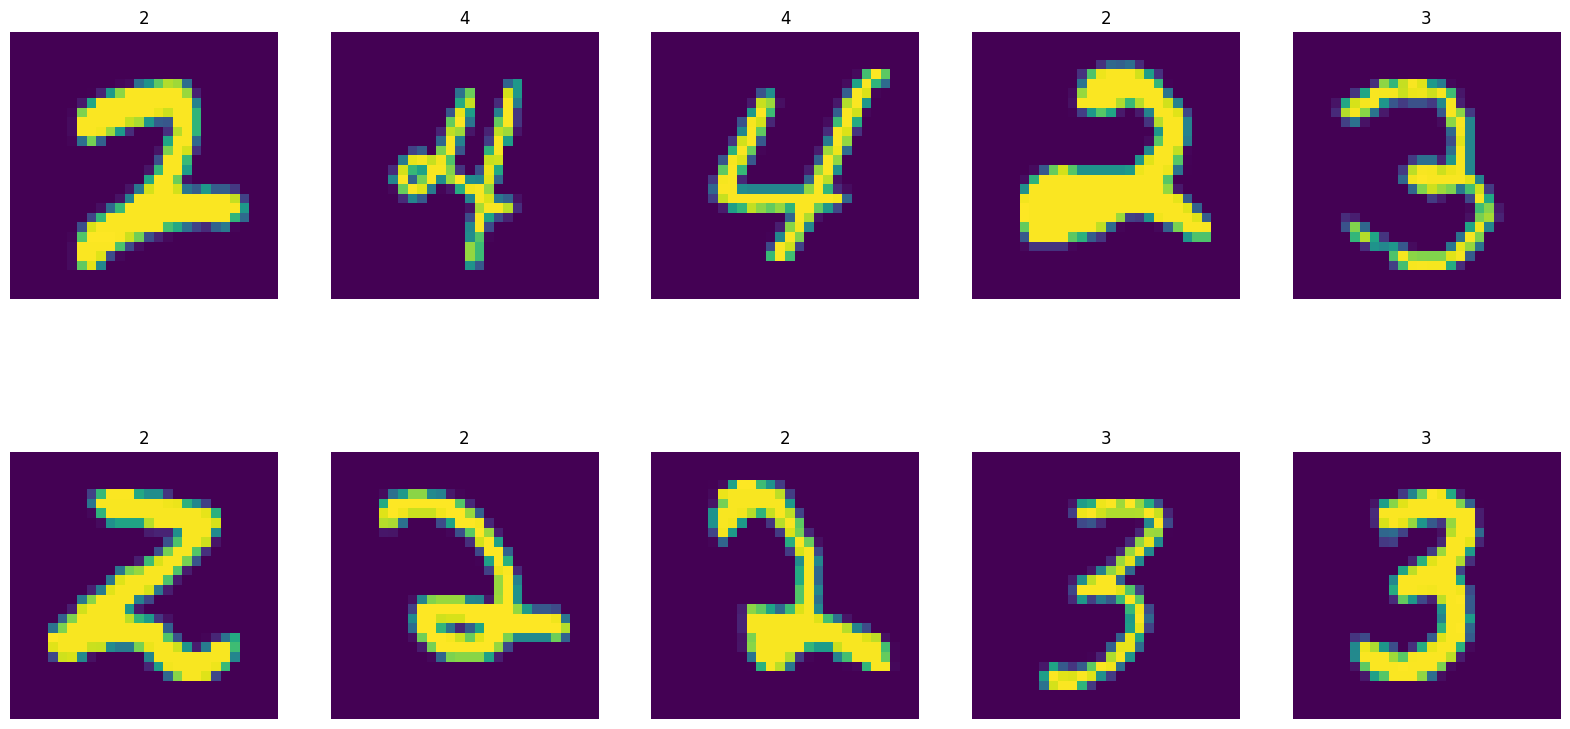

In [6]:
random_index = np.random.randint(0, len(df), size=10)
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i // 5, i % 5].imshow(df.iloc[random_index[i]][1:].values.reshape(28, 28))
    ax[i // 5, i % 5].set_title(df.iloc[random_index[i]][0])
    ax[i // 5, i % 5].axis('off')

## Transforming the data to binary values i.e map to 0 to 1


In [7]:
# scaling the features to 0 to 1
# 0 to 255/2 are mapped to 0 and 255/2 - 255 are mapped to 1
# Map the pixel values from a range of 0 to 255 to 0 or 1. If a pixel value exceeds 127 its mapped to 1, otherwise 0.
df.iloc[:, 1:] = df.iloc[:, 1:] // 128

## Plot of the transformed binary mapped dataset as per figure 9.10 (PRML: Bishop)

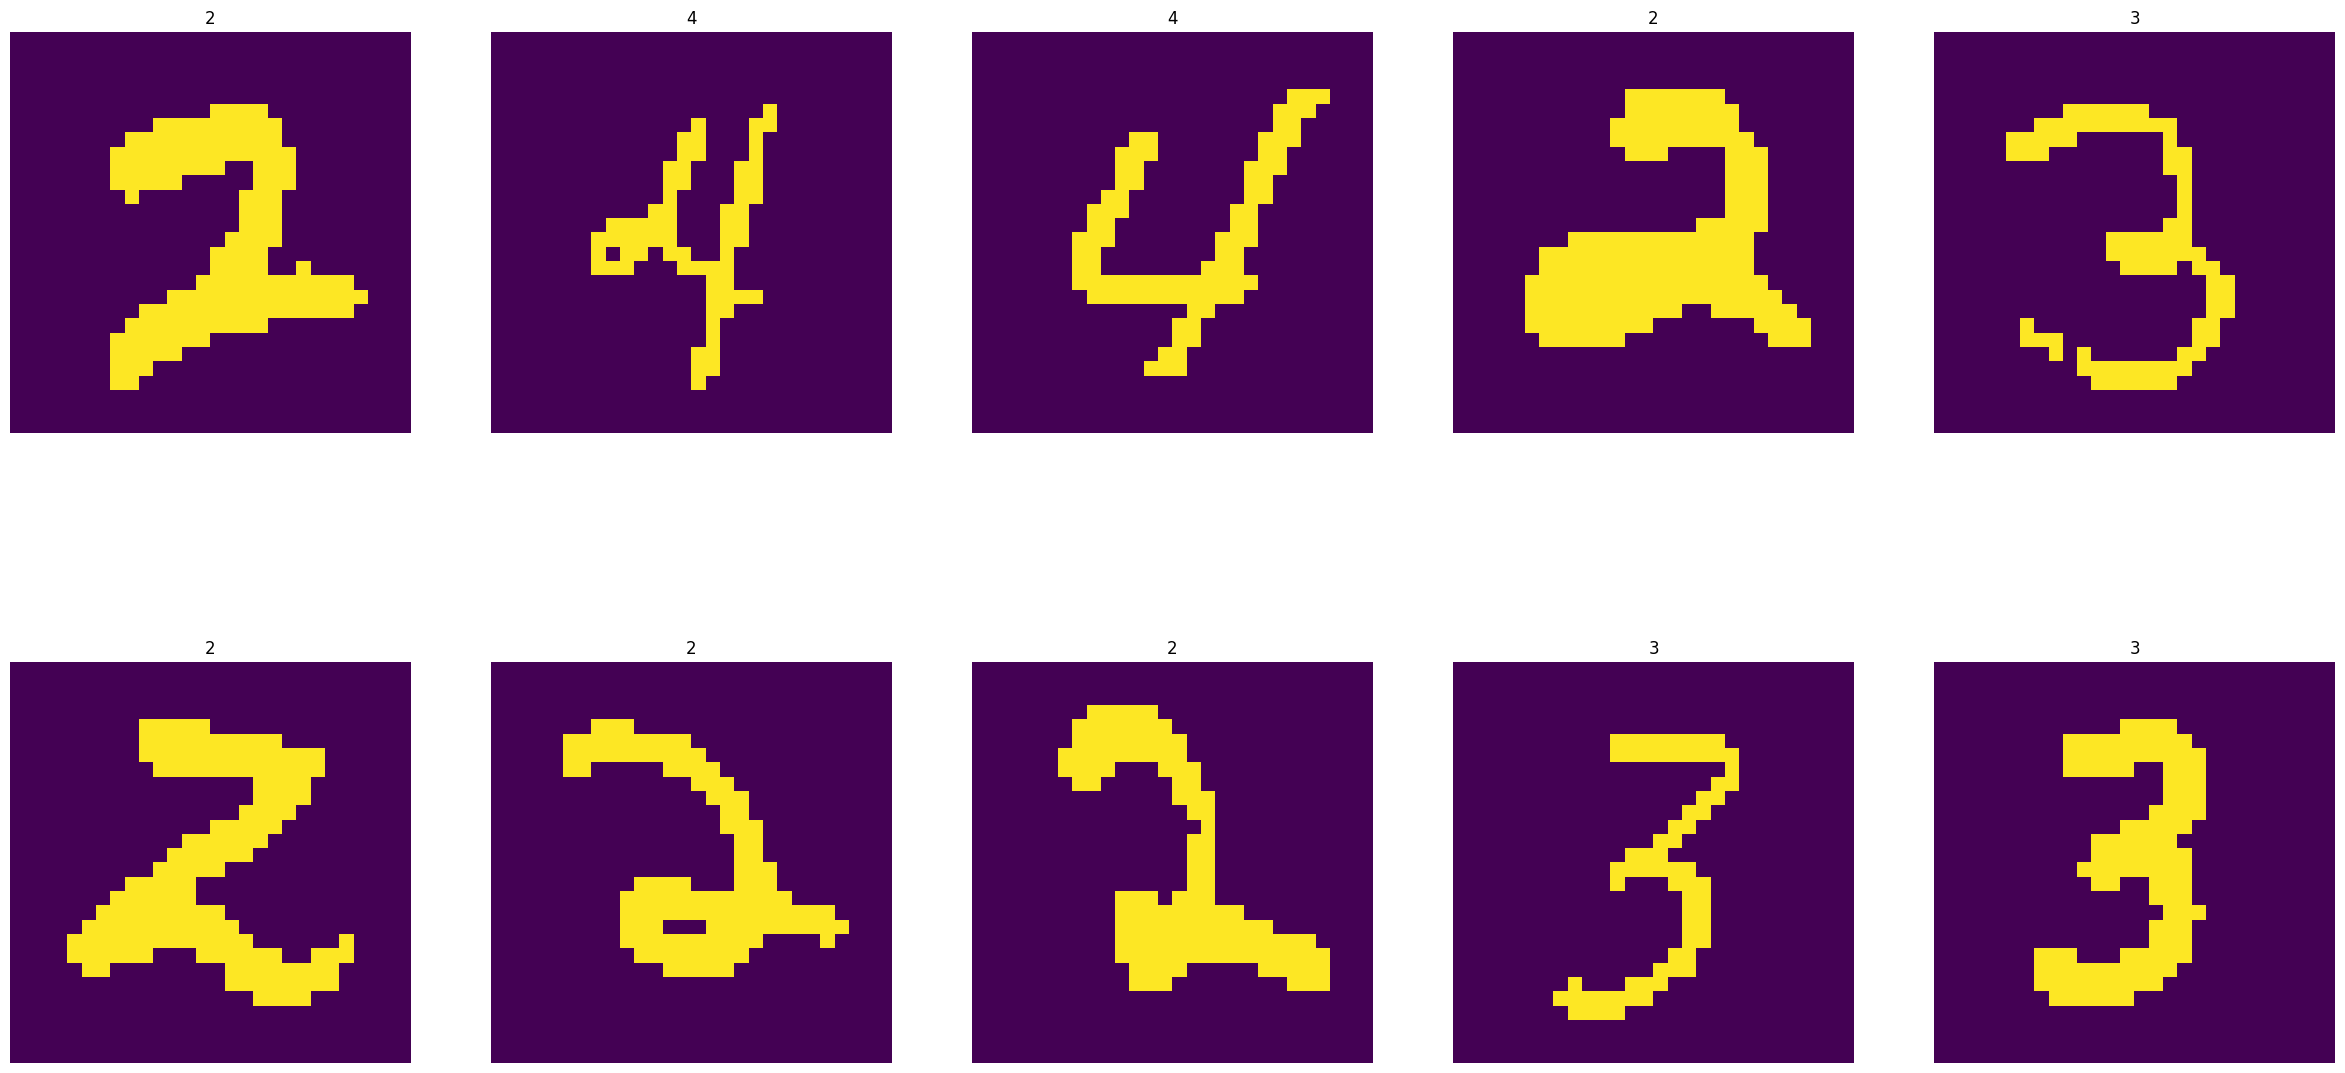

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(30, 15))
for i in range(10):
    # ax is an array of subplots, where each subplot is a 28x28 pixel image
    # imshow is a method of the subplot object that displays the image data in the subplot.
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].imshow(df.iloc[random_index[i]][1:].values.reshape(28, 28))
    ax[i // 5, i % 5].set_title(df.iloc[random_index[i]][0])

# Bernoulli Mixture Model 

## Bernoulli Distribution
A set of 784 binary variables $x_i$ , where $i = 1, . . . , 784$, each of which is
associated by a Bernoulli distribution with parameter $µ_i$ , so that
$$p(\textbf{x}|\boldsymbol{\mu}) = \prod_{i=1}^{784}\mu_i^{x_i}(1-\mu_i)^{(1-x_i)}$$

## E - step

Now, compute the responsibilities using the current parameter values

$$ \gamma(z_{nk}) = \frac{\pi_kp(\textbf{x}_n|\mu_k)}{ \sum_{j=1}^K\pi_jp(\textbf{x}_n|\mu_j)} $$



## M - step

Re-estimate the parameters using the current responsibilities  
$$\boldsymbol{\mu}_k^{new}=\frac{1}{N_k}\sum_{n=1}^{N}\gamma(z_{nk})\textbf{x}_n$$  
$$\pi_k^{new}=\frac{N_k}{N}$$  
where,  
$$N_k=\sum_{n=1}^N\gamma(z_{nk})$$

## Parameters 

 k: Number of clusters  
 N: Number of input rows  
 D: The length of each row/record (784)  
 pi:  $(\pi)$: Prior of each cluster (10x1 Matrix)  
 mu:  $(\mu)$: Bernoulli distribution of each cluster (10x784 Matrix)  
 gamma:  $(\gamma(z_{nk}))$: An NxK matrix. Probability of nth row belonging to kth cluster.  
 Nk:  $(N_k)$: the effective number of data points associated with cluster k. A Kx1 Matrix

In [12]:
class BernouliMixtureModel:
    def __init__(self):
        self.gamma = None
        self.mu = None
        self.pi = None
        self.k = None

    # Function to responsibilities

    def gamma_nk(self, X, n, k):
        gamma = self.pi[k] * self.pdf_bernoulli(X[n], self.mu[k])
        denominator_gamma_nk = 0
        for i in range(self.k):
            denominator_gamma_nk += self.pi[i] * \
                self.pdf_bernoulli(X[n], self.mu[i])
        if denominator_gamma_nk == 0:
            return 0.
        return gamma / denominator_gamma_nk


    # Function to compute Nk

    def N_k(self, X, k):
        N = X.shape[0]
        Nk = 0
        for i in range(N):
            # N_k will be number of point in kth cluster!  It will be anumber
            Nk += self.gamma[i, k]
        return Nk


    # Function to compute X_k

    def X_k(self, X, k):
        X_k = np.zeros(X.shape[1])
        for n in range(X.shape[0]):
            X_k += self.gamma[n, k] * X[n]
        return X_k / self.N_k(X, k)

    # Function to compute Mu_k
    
    def Mu_k(self, X, k):
        mu_k = self.X_k(X, k)
        return mu_k

    # Function to compute Pi_k

    def Pi_k(self, X, k):
        N_k = self.N_k(X, k)
        return N_k / X.shape[0]


    # Funtion for the formula for bernoulli pdf

    def pdf_bernoulli(self, x, mu):
        pdf = 1
        for i in range(len(x)):
            pdf *= (mu[i] ** x[i]) * ((1 - mu[i]) ** (1 - x[i]))
        return pdf

    # Funtion to predict 
    
    def predict(self, x):
        prob = np.zeros(self.k)
        for k in range(self.k):
            prob[k] = self.pi[k] * self.pdf_bernoulli(x, self.mu[k])
        return prob.argmax()

    # Main Algorithm
    # Function to Fit the model parameters to the data.

    def fit(self, X, k, max_iterations=100):
        self.k = k
        # initialize the prior probabilities of each cluster to be uniform
        self.pi = np.ones(k) / k
        # initialization of the mu between 0.25 and 0.75
        self.mu = np.random.uniform(0.25, 0.75, size=(k, X.shape[1]))
        # normalize the rows of mu to have unit length
        self.mu = self.mu / np.linalg.norm(self.mu, axis=1).reshape(-1, 1)
        # initialize the responsibilities for each data point and cluster to 0
        self.gamma = np.zeros((X.shape[0], k))
        # run the algorithm for a maximum of max_iter iterations
        for i in tqdm(range(max_iterations)):
            # print(i)

            #********************************************************************#
            # E-step: compute the responsibilities for each data point and cluster
            # ********************************************************************#

            for n in range(X.shape[0]):
                for k in range(self.k):
                    self.gamma[n, k] = self.gamma_nk(X, n, k)

            # ********************************************************************#
            # M-step: update the parameters of the model
            # ********************************************************************#
            
            for k in range(self.k):
                # update the mean of cluster k
                self.mu[k] = self.Mu_k(X, k)
                # update the prior probability of cluster k
                self.pi[k] = self.Pi_k(X, k)
        return self

### Running the Algorithm

In [13]:
# This line of code is fitting a Bayesian Gaussian mixture model (BGM) to a subset of data in df, specifically the first 600 rows of columns 1 through the end (i.e., all pixel values) using 3 components.
bmm = BernouliMixtureModel()
bmm.fit(df.iloc[0:600, 1:].values, 3)
mu = bmm.mu

100%|██████████| 100/100 [05:48<00:00,  3.48s/it]


### Display the image of the mean (average) of the data points belonging to the corresponding cluster

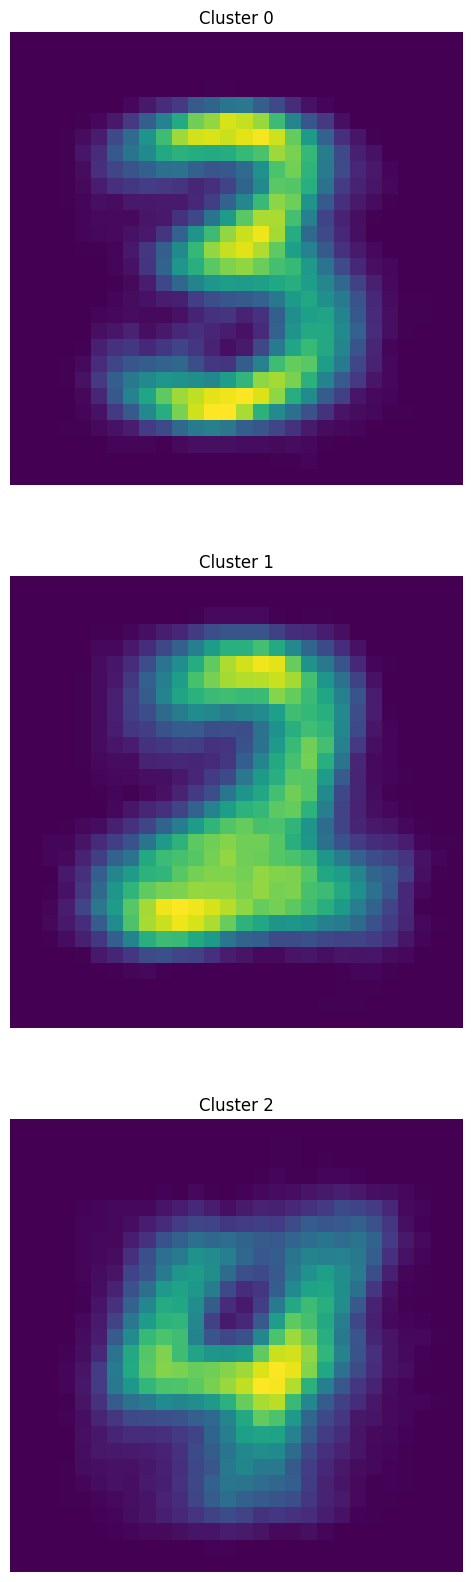

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
for i in range(3):
    ax[i].axis('off')
    # The imshow() function is called to display the image of the mean (average) of the data points belonging to the corresponding cluster
    ax[i].imshow(mu[i].reshape(28, 28))
    ax[i].set_title('Cluster {}'.format(i))

### Assigning labels to each data point

In [15]:
# prompt the user to name the clusters
cluster_labels = {'cluster0': 0, 'cluster1': 1, 'cluster2': 2}
cluster_labels[0] = input('Enter the label for cluster 0: ')
cluster_labels[1] = input('Enter the label for cluster 1: ')
cluster_labels[2] = input('Enter the label for cluster 2: ')

In [16]:
# Create an empty numpy array to hold the resulting cluster labels
res_cluster_labels = np.zeros(df.shape[0])
for i in range(df.shape[0]):
    # Use the trained clustering algorithm to predict the cluster for the current data point
    # by passing the values of all columns except the first one to the predict() method
    res_cluster_labels[i] = bmm.predict(df.iloc[i, 1:].values)
    res_cluster_labels[i] = cluster_labels[res_cluster_labels[i]]


### Computing the accuracy

In [17]:
correct_counter = 0
for i in range(df.shape[0]):
    if res_cluster_labels[i] == df.iloc[i, 0]:
        correct_counter += 1
accuracy = correct_counter / df.shape[0]
print('Accuracy: ', accuracy)


Accuracy:  0.8616666666666667


In [15]:
print(df.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


### Compute the cluster assignments using the mixture of Bernoulli distributions

In [18]:
from sklearn.mixture import GaussianMixture
X = df.drop('label', axis=1)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)
predicted_clusters = gmm.predict(X)

# Map the predicted cluster labels to the cluster labels defined by the user
predicted_clusters = np.array(
    [cluster_labels[f'cluster{x}'] for x in predicted_clusters])

# Extract the true labels
true_labels = df['label'].values

### Compute the confusion matrix

In [19]:
ConfusionMatrix = confusion_matrix(true_labels, predicted_clusters)

### Plot the confusion matrix

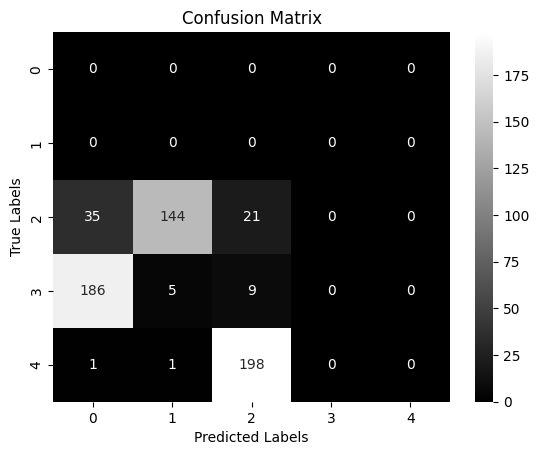

In [20]:
# Plot the confusion matrix
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='gray')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()